In [1]:
import warnings
warnings.filterwarnings("ignore")
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from wordcloud import WordCloud
import re
import os
import datetime as dt
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem.snowball import SnowballStemmer
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.multiclass import OneVsRestClassifier
from sklearn.linear_model import SGDClassifier
from sklearn import metrics
from sklearn.metrics import f1_score,precision_score,recall_score
from sklearn import svm
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from datetime import datetime

In [2]:
dataset = pd.read_csv('Train.csv')
dataset.head()

,Id,Title,Body,Tags
0,1,How to check if an uploaded file is an image w...,<p>I'd like to check if an uploaded file is an...,php image-processing file-upload upload mime-t...
1,2,How can I prevent firefox from closing when I ...,"<p>In my favorite editor (vim), I regularly us...",firefox
2,3,R Error Invalid type (list) for variable,<p>I am import matlab file and construct a dat...,r matlab machine-learning
3,4,How do I replace special characters in a URL?,"<p>This is probably very simple, but I simply ...",c# url encoding
4,5,How to modify whois contact details?,<pre><code>function modify(.......)\n{\n $mco...,php api file-get-contents


In [3]:
dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6034195 entries, 0 to 6034194
Data columns (total 4 columns):
 #   Column  Dtype 
---  ------  ----- 
 0   Id      int64 
 1   Title   object
 2   Body    object
 3   Tags    object
dtypes: int64(1), object(3)
memory usage: 184.1+ MB


In [4]:
dataset['Tags'].isnull().sum()


8

In [5]:
df = dataset.dropna()

In [6]:
df['Tags'].isnull().sum()

0

In [10]:
df = df[0:500000]

In [11]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split())
tag_dtm = vectorizer.fit_transform(df['Tags'])

In [12]:
print("Number of data points :", tag_dtm.shape[0])
print("Number of unique tags :", tag_dtm.shape[1])

Number of data points : 500000
Number of unique tags : 30429


In [13]:
tags = vectorizer.get_feature_names()
print("Some of the tags we have :", tags[:10])

Some of the tags we have : ['.a', '.app', '.aspxauth', '.bash-profile', '.class-file', '.doc', '.each', '.emf', '.exe', '.hgtags']


In [14]:
freqs = tag_dtm.sum(axis=0).A1 #count frequency of each tag
result = dict(zip(tags, freqs)) #store tags along with its frequency
result

{'.a': 3,
 '.app': 8,
 '.aspxauth': 3,
 '.bash-profile': 13,
 '.class-file': 5,
 '.doc': 3,
 '.each': 28,
 '.emf': 6,
 '.exe': 2,
 '.hgtags': 2,
 '.htaccess': 1735,
 '.htpasswd': 4,
 '.lib': 2,
 '.lrc': 1,
 '.mov': 1,
 '.net': 13574,
 '.net-1.0': 1,
 '.net-1.1': 24,
 '.net-2.0': 197,
 '.net-3.0': 4,
 '.net-3.5': 444,
 '.net-4.0': 576,
 '.net-4.0-beta-2': 1,
 '.net-4.5': 76,
 '.net-assembly': 70,
 '.net-authorization': 2,
 '.net-cf-3.5': 5,
 '.net-client-profile': 6,
 '.net-framework': 37,
 '.net-framework-source': 2,
 '.net-framework-version': 9,
 '.net-gadgeteer': 2,
 '.net-install': 3,
 '.net-micro-framework': 12,
 '.net-reflector': 3,
 '.net-remoting': 18,
 '.net-security': 1,
 '.net-services': 3,
 '.net2.0': 2,
 '.net3.5': 5,
 '.net4.0': 3,
 '.netrc': 2,
 '.nettiers': 5,
 '.obj': 6,
 '.post': 9,
 '.procmailrc': 1,
 '.profile': 3,
 '.railsrc': 1,
 '.rdlc': 5,
 '.refresh': 1,
 '.sdf': 3,
 '.vdproj': 1,
 '.war': 3,
 '.wav': 3,
 '.when': 1,
 '.x': 2,
 '1080p': 9,
 '10gbethernet': 4,
 '

In [15]:
import csv

with open('tag_counts_dict_dtm.csv', 'w') as csv_file:
    writer = csv.writer(csv_file)
    for key, value in result.items():
        writer.writerow([key, value])
tag_df = pd.read_csv("tag_counts_dict_dtm.csv", names=['Tags', 'Counts'])
tag_df.head()

,Tags,Counts
0,.a,3
1,.app,8
2,.aspxauth,3
3,.bash-profile,13
4,.class-file,5


In [16]:
tag_df_sorted = tag_df.sort_values(['Counts'], ascending=False)
tag_counts = tag_df_sorted['Counts'].values

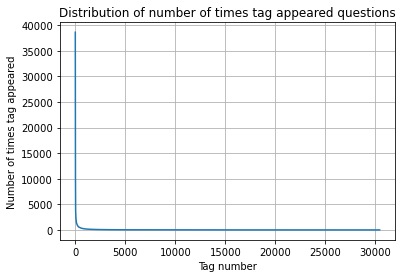

In [17]:
plt.plot(tag_counts)
plt.title("Distribution of number of times tag appeared questions")
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.show()

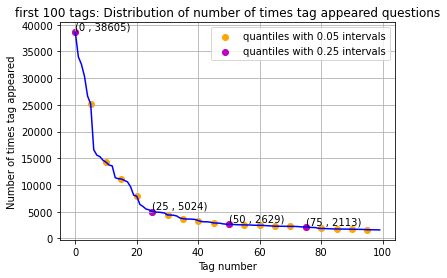

20 [38605 25173 14260 11120  7904  5024  4373  3696  3332  2895  2629  2523
  2450  2283  2246  2113  1850  1756  1718  1612]


In [18]:
plt.plot(tag_counts[0:100], c='b')
plt.scatter(x=list(range(0,100,5)), y=tag_counts[0:100:5], c='orange', label="quantiles with 0.05 intervals")
# quantiles with 0.25 difference
plt.scatter(x=list(range(0,100,25)), y=tag_counts[0:100:25], c='m', label = "quantiles with 0.25 intervals")

for x,y in zip(list(range(0,100,25)), tag_counts[0:100:25]):
    plt.annotate(s="({} , {})".format(x,y), xy=(x,y), xytext=(x-0.05, y+500))

plt.title('first 100 tags: Distribution of number of times tag appeared questions')
plt.grid()
plt.xlabel("Tag number")
plt.ylabel("Number of times tag appeared")
plt.legend()
plt.show()
print(len(tag_counts[0:100:5]), tag_counts[0:100:5])

In [19]:
lst_tags_gt_10k = tag_df[tag_df.Counts>10000].Tags
print ('{} Tags are used more than 10000 times'.format(len(lst_tags_gt_10k)))
lst_tags_gt_100k = tag_df[tag_df.Counts>100000].Tags
print ('{} Tags are used more than 100000 times'.format(len(lst_tags_gt_100k)))

18 Tags are used more than 10000 times
0 Tags are used more than 100000 times


In [20]:
tag_quest_count = tag_dtm.sum(axis=1).tolist()
tag_quest_count=[int(j) for i in tag_quest_count for j in i]
print ('We have total {} datapoints.'.format(len(tag_quest_count)))

print(tag_quest_count[:5])

We have total 500000 datapoints.
[5, 1, 3, 3, 3]


In [21]:
print( "Maximum number of tags per question: %d"%max(tag_quest_count))
print( "Minimum number of tags per question: %d"%min(tag_quest_count))
print( "Avg. number of tags per question: %f"% ((sum(tag_quest_count)*1.0)/len(tag_quest_count)))

Maximum number of tags per question: 5
Minimum number of tags per question: 1
Avg. number of tags per question: 2.886944


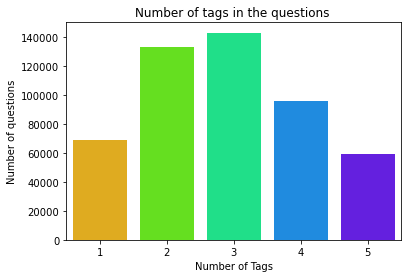

In [22]:
sns.countplot(tag_quest_count, palette='gist_rainbow')
plt.title("Number of tags in the questions ")
plt.xlabel("Number of Tags")
plt.ylabel("Number of questions")
plt.show()

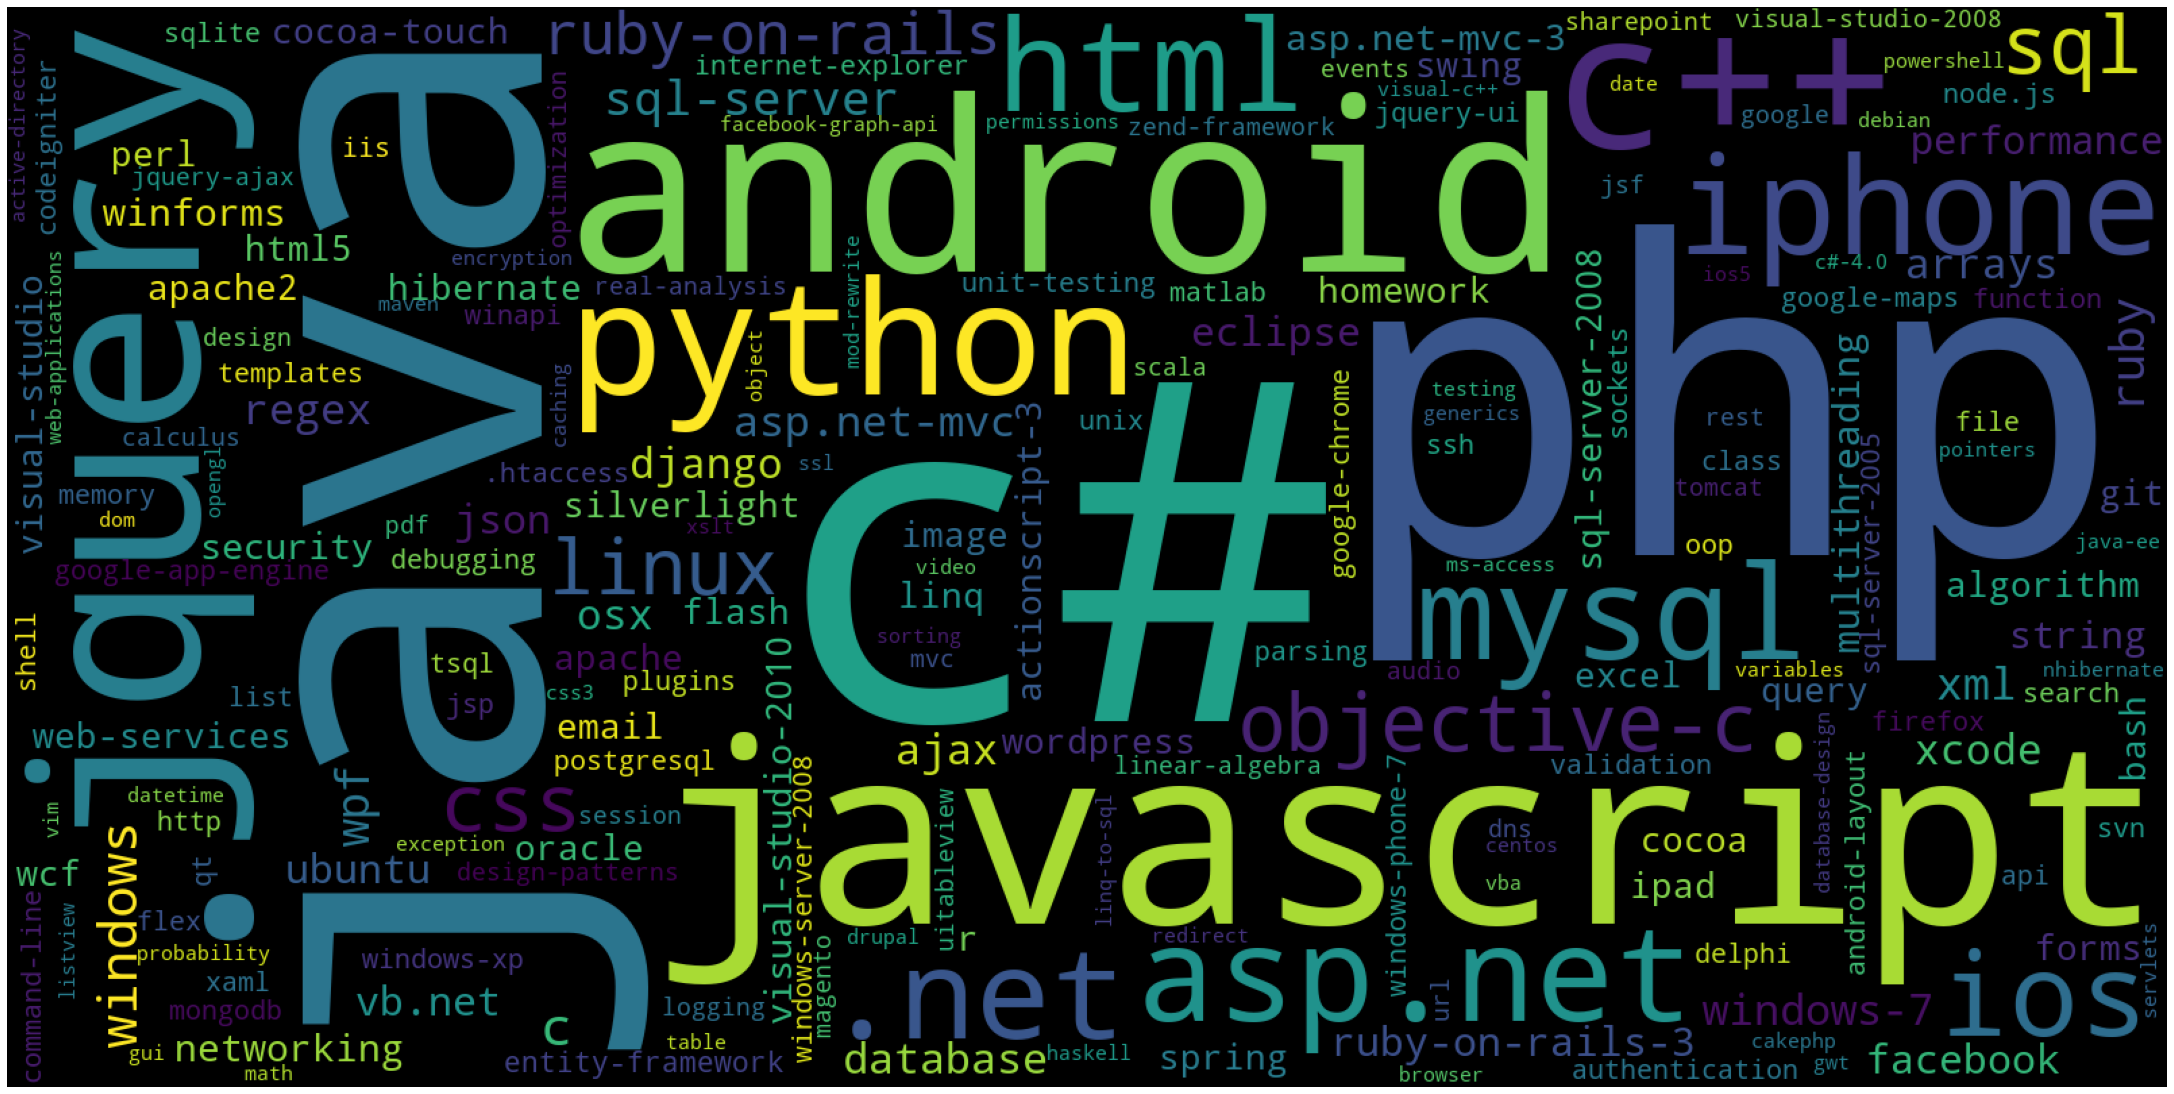

Time taken to run this cell : 0:00:03.968891


In [39]:
start = datetime.now()

# Lets first convert the 'result' dictionary to 'list of tuples'
tup = dict(result.items())
#Initializing WordCloud using frequencies of tags.
wordcloud = WordCloud(    background_color='black',
                          width=1600,
                          height=800,
                    ).generate_from_frequencies(tup)

fig = plt.figure(figsize=(30,20))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
fig.savefig("tag.png")
plt.show()
print("Time taken to run this cell :", datetime.now() - start)

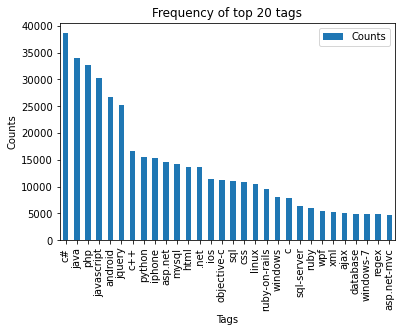

In [40]:
i=np.arange(30)
tag_df_sorted.head(30).plot(kind='bar')
plt.title('Frequency of top 20 tags')
plt.xticks(i, tag_df_sorted.head(30)['Tags'])
plt.xlabel('Tags')
plt.ylabel('Counts')
plt.show()

In [41]:
def striphtml(data):
    cleanr = re.compile('<.*?>')
    cleantext = re.sub(cleanr, ' ', str(data))
    return cleantext
stop_words = set(stopwords.words('english'))
stemmer = SnowballStemmer("english")

In [42]:
title, question, tags = df['Title'].values, df['Body'].values , df.Tags.values

In [43]:
title[0]

b'How to check if an uploaded file is an image without mime type?'

In [28]:
preprocessed_data_list=[]
questions_with_code=0
len_pre=0
len_post=0
print(type(question))
questions_proccesed = 0
for i in range(len(title)):
    is_code = 0
    if '<code>' in question[i]:
        questions_with_code+=1
        is_code = 1
    x = len(question[i])+len(title[i])
    len_pre+=x
    code = str(re.findall(r'<code>(.*?)</code>', question[i], flags=re.DOTALL))
    question[i]=re.sub('<code>(.*?)</code>', '', question[i], flags=re.MULTILINE|re.DOTALL)
    question[i]=striphtml(question[i].encode('utf-8'))
    title[i]=title[i].encode('utf-8')
    question[i]=re.sub(r'[^A-Za-z0-9#+.\-]+',' ',question[i])
    words=word_tokenize(str(question[i].lower()))
    question[i]=' '.join(str(stemmer.stem(j)) for j in words if j not in stop_words and (len(j)!=1 or j=='c'))
    len_post+=len(question[i])
    tup = (question[i],code,tags[i],x,len(question[i]),is_code)
    questions_proccesed += 1
    if (questions_proccesed%100000==0):
        print("number of questions completed=",questions_proccesed)

no_dup_avg_len_pre=(len_pre*1.0)/questions_proccesed
no_dup_avg_len_post=(len_post*1.0)/questions_proccesed

print( "Avg. length of questions(Title+Body) before processing: %d"%no_dup_avg_len_pre)
print( "Avg. length of questions(Title+Body) after processing: %d"%no_dup_avg_len_post)
print ("Percent of questions containing code: %d"%((questions_with_code*100.0)/questions_proccesed))

<class 'numpy.ndarray'>
number of questions completed= 100000
number of questions completed= 200000
number of questions completed= 300000
number of questions completed= 400000
number of questions completed= 500000
Avg. length of questions(Title+Body) before processing: 1148
Avg. length of questions(Title+Body) after processing: 301
Percent of questions containing code: 56


In [44]:
question[2]

'import matlab file construct data frame matlab file contain two column row maintain cell matrix construct datafram run random forest get follow error code import matlab file construct datafram structur matlab input file load matlab file'

In [45]:
preprocessed_data = pd.DataFrame({'question': question, 'tags':tags})

In [46]:
preprocessed_data.head()

,question,tags
0,like check upload file imag file e.g png jpg j...,php image-processing file-upload upload mime-t...
1,favorit editor vim regular use ctrl-w execut c...,firefox
2,import matlab file construct data frame matlab...,r matlab machine-learning
3,probabl simpl simpli find answer basicali want...,c# url encoding
4,use modifi function display warn mesag pleas h...,php api file-get-contents


In [47]:
print("number of data points in sample :", preprocessed_data.shape[0])
print("number of dimensions :", preprocessed_data.shape[1])

number of data points in sample : 500000
number of dimensions : 2


In [48]:
vectorizer = CountVectorizer(tokenizer = lambda x: x.split(), binary='true')
multilabel_y = vectorizer.fit_transform(preprocessed_data['tags'])

In [49]:
def tags_to_choose(n):
    t = multilabel_y.sum(axis=0).tolist()[0]
    sorted_tags_i = sorted(range(len(t)), key=lambda i: t[i], reverse=True)
    multilabel_yn=multilabel_y[:,sorted_tags_i[:n]]
    return multilabel_yn

def questions_explained_fn(n):
    multilabel_yn = tags_to_choose(n)
    x= multilabel_yn.sum(axis=1)
    return (np.count_nonzero(x==0))

In [50]:
questions_explained = []
total_tags=multilabel_y.shape[1]
total_qs=preprocessed_data.shape[0]
for i in range(500, total_tags, 100):
    questions_explained.append(np.round(((total_qs-questions_explained_fn(i))/total_qs)*100,3))

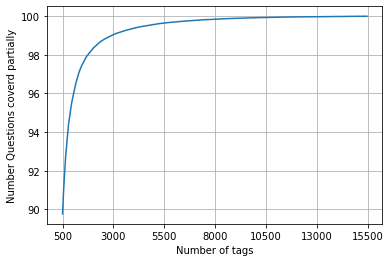

with  5500 tags we are covering  99.052 % of questions
with  500 tags we are covering  89.761 % of questions


In [51]:
fig, ax = plt.subplots()
ax.plot(questions_explained)
xlabel = list(500+np.array(range(-50,450,50))*50)
ax.set_xticklabels(xlabel)
plt.xlabel("Number of tags")
plt.ylabel("Number Questions coverd partially")
plt.grid()
plt.show()
# you can choose any number of tags based on your computing power, minimun is 500(it covers 90% of the tags)
print("with ",5500,"tags we are covering ",questions_explained[50],"% of questions")
print("with ",500,"tags we are covering ",questions_explained[0],"% of questions")

In [61]:
multilabel_yx = tags_to_choose(500)
print("number of questions that are not covered :", questions_explained_fn(5500),"out of ", total_qs)

number of questions that are not covered : 4740 out of  500000


In [62]:
train_datasize = 400000

In [63]:
x_train=preprocessed_data.head(train_datasize)
x_test=preprocessed_data.tail(preprocessed_data.shape[0] - 400000)

y_train = multilabel_yx[0:train_datasize,:]
y_test = multilabel_yx[train_datasize:preprocessed_data.shape[0],:]

In [64]:
print("Number of data points in train data :", y_train.shape)
print("Number of data points in test data :", y_test.shape)

Number of data points in train data : (400000, 500)
Number of data points in test data : (100000, 500)


In [65]:
start = datetime.now()
vectorizer = TfidfVectorizer(min_df=0.00009, max_features=200000, smooth_idf=True, norm="l2", \
                             tokenizer = lambda x: x.split(), sublinear_tf=False, ngram_range=(1,2))

In [66]:
x_train_multilabel = vectorizer.fit_transform(x_train['question'])
x_test_multilabel = vectorizer.transform(x_test['question'])
print("Time taken to run this cell :", datetime.now() - start)

Time taken to run this cell : 0:01:13.941097


In [67]:
print("Dimensions of train data X:",x_train_multilabel.shape, "Y :",y_train.shape)
print("Dimensions of test data X:",x_test_multilabel.shape,"Y:",y_test.shape)

Dimensions of train data X: (400000, 72957) Y : (400000, 500)
Dimensions of test data X: (100000, 72957) Y: (100000, 500)


In [68]:
start = datetime.now()
print('Classifying data...')
classifier = OneVsRestClassifier(SGDClassifier(loss='log', alpha=0.00001, penalty='l1'), n_jobs=-1)
classifier.fit(x_train_multilabel, y_train)
predictions = classifier.predict (x_test_multilabel)

print('Calculating Accuracy and loss...')
print("Accuracy :",metrics.accuracy_score(y_test, predictions))
print("Hamming loss ",metrics.hamming_loss(y_test,predictions))


precision = precision_score(y_test, predictions, average='micro')
recall = recall_score(y_test, predictions, average='micro')
f1 = f1_score(y_test, predictions, average='micro')
 
print("Micro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

precision = precision_score(y_test, predictions, average='macro')
recall = recall_score(y_test, predictions, average='macro')
f1 = f1_score(y_test, predictions, average='macro')
 
print("Macro-average quality numbers")
print("Precision: {:.4f}, Recall: {:.4f}, F1-measure: {:.4f}".format(precision, recall, f1))

print (metrics.classification_report(y_test, predictions))
print("Time taken to run this cell :", datetime.now() - start)

Classifying data...
Calculating Accuracy and loss...
Accuracy : 0.18597
Hamming loss  0.00311018
Micro-average quality numbers
Precision: 0.6776, Recall: 0.2510, F1-measure: 0.3663
Macro-average quality numbers
Precision: 0.4982, Recall: 0.1781, F1-measure: 0.2508
              precision    recall  f1-score   support

           0       0.63      0.18      0.28      7761
           1       0.75      0.32      0.45      6749
           2       0.80      0.41      0.54      6601
           3       0.69      0.32      0.44      6037
           4       0.92      0.63      0.75      5320
           5       0.81      0.50      0.61      5234
           6       0.79      0.37      0.50      3348
           7       0.84      0.43      0.57      3117
           8       0.68      0.30      0.42      3146
           9       0.78      0.33      0.46      2948
          10       0.77      0.46      0.57      2823
          11       0.48      0.14      0.22      2792
          12       0.55      0.0